### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


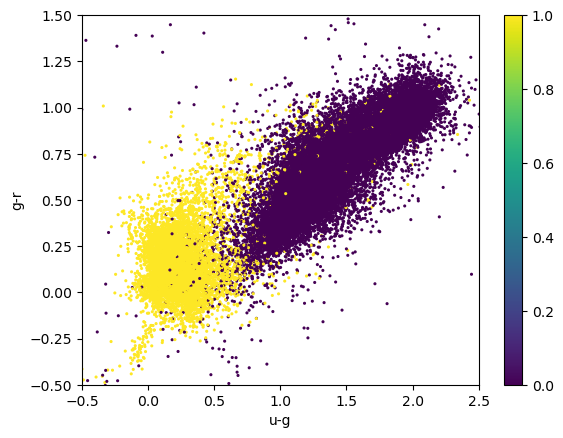

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#1.

data = np.load('/Users/sabr/ASTR_3300_S2025/coursework/homeworks/hw_data/hw8_data_1.npy')
print(data.dtype.names)
u_g = data['u']-data['g']
g_r = data['g']-data['r']
r_i = data['r']-data['i']
i_z = data['i']-data['z']
redshift = data['redshift']
specclass = data['specClass']
y = np.unique(specclass,return_inverse=True)[1]

#2.

plt.scatter(u_g, g_r, c=y, edgecolor="None", s=5)
plt.colorbar()
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.show()

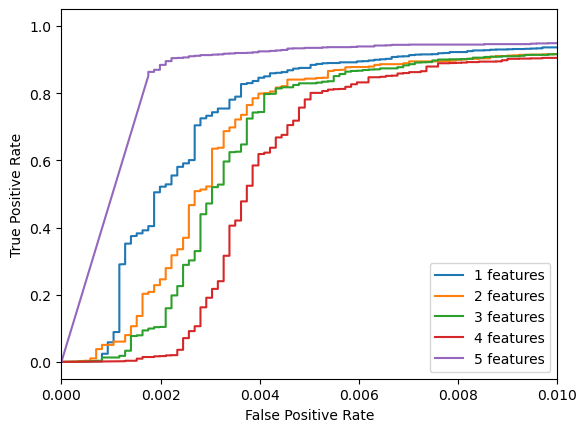

Redshift seems to make the classification much easier.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

#3.

X = np.column_stack([u_g,g_r,r_i,i_z,redshift])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#4.

for n in range(1, 6):
    gnb = GaussianNB()
    gnb.fit(X_train[:, :n], y_train)
    quasar = np.where(gnb.classes_ == 1)[0][0]
    y_score = gnb.predict_proba(X_test[:, :n])[:, quasar]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f'{n} features')

plt.xlim(0, 0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('Redshift seems to make the classification much easier.')

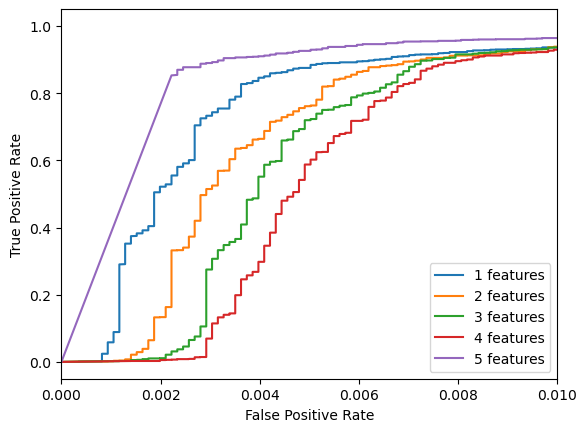

In [3]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

#5.

for n in range(1, 6):
    qda = QDA()
    qda.fit(X_train[:, :n], y_train)
    quasar = np.where(qda.classes_ == 1)[0][0]
    y_score = qda.predict_proba(X_test[:, :n])[:, quasar]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f'{n} features')

plt.xlim(0, 0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

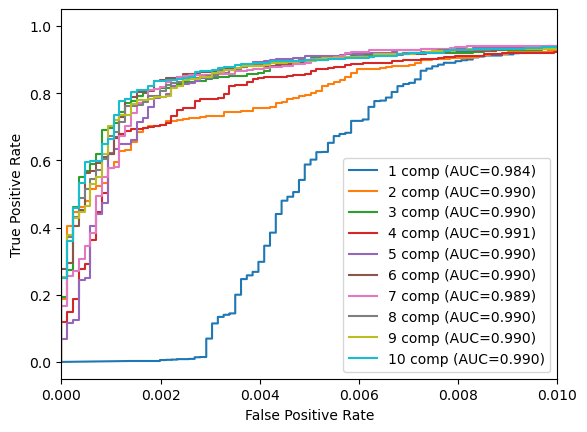

Best number of components: 4 (AUC = 0.9908)


In [4]:
from astroML.classification import GMMBayes
from sklearn.metrics import auc

#6.

X_train_new = np.delete(X_train, 4, axis=1)
X_test_new = np.delete(X_test, 4, axis=1)

best_auc = 0
best_n = 1

for n in range(1, 11):
    gmmb = GMMBayes(n_components=n)
    gmmb.fit(X_train_new, y_train)
    quasar = np.where(gmmb.classes_ == 1)[0][0]
    y_score = gmmb.predict_proba(X_test_new)[:, quasar]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_n = n
    plt.plot(fpr, tpr, label=f'{n} comp (AUC={roc_auc:.3f})')

plt.xlim(0, 0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f'Best number of components: {best_n} (AUC = {best_auc:.4f})')

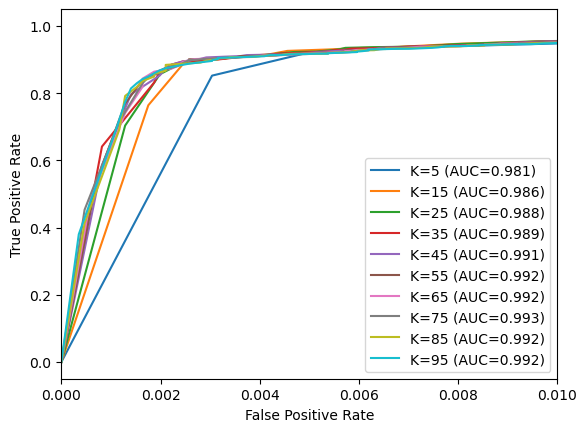

Best number of neighbors: 75 (AUC = 0.9925)


In [5]:
from sklearn.neighbors import KNeighborsClassifier

#7.

best_auc = 0
best_k = 5

for k in range(5, 101, 10):
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(X_train_new, y_train)
    quasar = np.where(knc.classes_ == 1)[0][0]
    y_score = knc.predict_proba(X_test_new)[:, quasar]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_k = k
    plt.plot(fpr, tpr, label=f'K={k} (AUC={roc_auc:.3f})')

plt.xlim(0, 0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f'Best number of neighbors: {best_k} (AUC = {best_auc:.4f})')

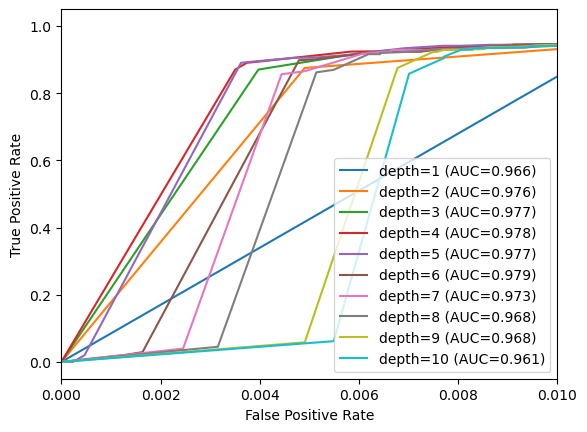

Best max depth: 6 (AUC = 0.9790)


In [6]:
from sklearn.tree import DecisionTreeClassifier

#8.

best_auc = 0
best_d = 1

for d in range(1, 11):
    dtree = DecisionTreeClassifier(max_depth=d)
    dtree.fit(X_train_new, y_train)
    quasar = np.where(dtree.classes_ == 1)[0][0]
    y_score = dtree.predict_proba(X_test_new)[:, quasar]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_d = d
    plt.plot(fpr, tpr, label=f'depth={d} (AUC={roc_auc:.3f})')

plt.xlim(0, 0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f'Best max depth: {best_d} (AUC = {best_auc:.4f})')

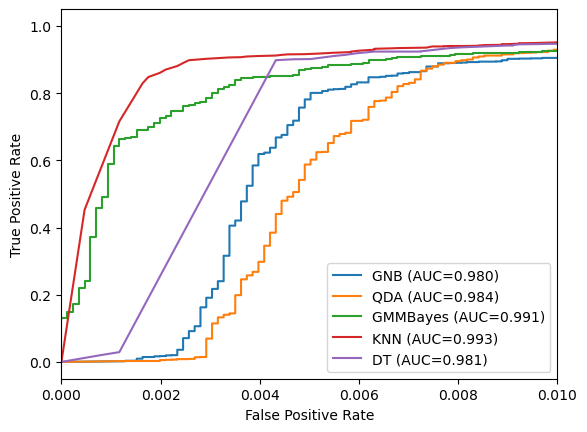

best model: KNN


In [7]:
#9.

gnb = GaussianNB()
qda = QDA()
gmmb = GMMBayes(n_components=best_n)
knc = KNeighborsClassifier(n_neighbors=best_k)
dtree = DecisionTreeClassifier(max_depth=best_d)


gnb.fit(X_train_new, y_train)
quasar = np.where(gnb.classes_ == 1)[0][0]
y_score = gnb.predict_proba(X_test_new)[:, quasar]
fpr, tpr, _ = roc_curve(y_test, y_score)
gnb_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'GNB (AUC={gnb_auc:.3f})')

qda.fit(X_train_new, y_train)
quasar = np.where(qda.classes_ == 1)[0][0]
y_score = qda.predict_proba(X_test_new)[:, quasar]
fpr, tpr, _ = roc_curve(y_test, y_score)
qda_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'QDA (AUC={qda_auc:.3f})')

gmmb.fit(X_train_new, y_train)
quasar = np.where(gmmb.classes_ == 1)[0][0]
y_score = gmmb.predict_proba(X_test_new)[:, quasar]
fpr, tpr, _ = roc_curve(y_test, y_score)
gmmb_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'GMMBayes (AUC={gmmb_auc:.3f})')

knc.fit(X_train_new, y_train)
quasar = np.where(knc.classes_ == 1)[0][0]
y_score = knc.predict_proba(X_test_new)[:, quasar]
fpr, tpr, _ = roc_curve(y_test, y_score)
knc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'KNN (AUC={knc_auc:.3f})')

dtree.fit(X_train_new, y_train)
quasar = np.where(dtree.classes_ == 1)[0][0]
y_score = dtree.predict_proba(X_test_new)[:, quasar]
fpr, tpr, _ = roc_curve(y_test, y_score)
dtree_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'DT (AUC={dtree_auc:.3f})')

plt.xlim(0, 0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('best model: KNN')

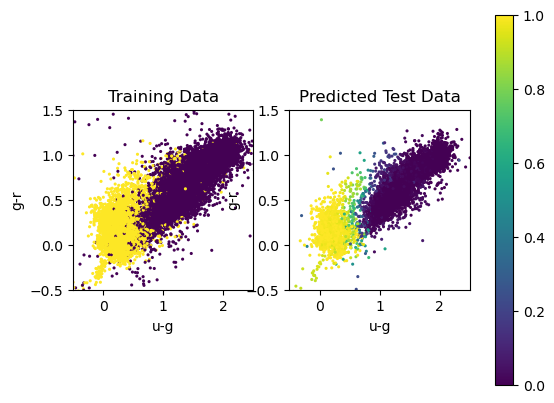

In [8]:
#10.

knc.fit(X_train_new, y_train)
quasar = np.where(knc.classes_ == 1)[0][0]
y_score = knc.predict_proba(X_test_new)[:, quasar]

fig, ax = plt.subplots(1, 2)
plot = ax[0].scatter(X_train_new[:,0], X_train_new[:,1], c=y_train, edgecolor="None", s=5)
ax[0].set_xlabel('u-g')
ax[0].set_ylabel('g-r')
ax[0].set_title('Training Data')
ax[0].set_xlim(-0.5,2.5)
ax[0].set_ylim(-0.5,1.5)
ax[0].set_box_aspect(1)
ax[1].scatter(X_test_new[:,0], X_test_new[:,1], c=y_score, edgecolor="None", s=5)
ax[1].set_xlabel('u-g')
ax[1].set_ylabel('g-r')
ax[1].set_title('Predicted Test Data')
ax[1].set_xlim(-0.5,2.5)
ax[1].set_ylim(-0.5,1.5)
ax[1].set_box_aspect(1)
fig.colorbar(plot, ax=ax)
plt.show()

<span style="color:green">NP: Correct! Good job! </span>